# Yelp Review Rating Prediction Using Text
### Tatiana Romanchishina

In [2]:
### libraries
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
import itertools
import random
import scipy
import six
import re

from __future__ import print_function
from pprint import pprint
import time as time
import seaborn as sns
sns.set()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


#### Connect to Amazon S3 storage and download the file

In [2]:
import boto
import boto.s3.connection
from boto.s3.connection import S3Connection
conn = S3Connection()
bucket = conn.get_bucket('yelp-rest-reviews')
for key in bucket.list():
        print ("{name}\t{size}\t{modified}".format(
                name = key.name,
                size = key.size,
                modified = key.last_modified,
                ))

reviews_all.csv	663830339	2016-05-03T17:35:07.000Z


In [3]:
key = bucket.get_key('reviews_all.csv')
key.get_contents_to_filename('/home/ubuntu/yelp/reviews_all.csv')

### Load the data into a dataframe

In [3]:
path = r'/home/ubuntu/yelp/reviews_all.csv'
reviews = pd.read_csv(path)
reviews['Rating_nom'] = ["one" if Rating == 1 else "two" if Rating == 2 else "three" if Rating == 3 
                else "four" if Rating == 4 else "five" for Rating in reviews.Rating]
reviews = reviews[['Text','Rating_nom']]
reviews.head()

,Text,Rating_nom
0,I was underwhelmed I ordered the filet and i...,two
1,Fun environment friendly staff and decent foo...,four
2,Benjamin s is good bar restaurant on the Nort...,five
3,This place is awesome The food is great and t...,five
4,We loved Eddie and his very appeasing accent ...,five


In [3]:
reviews.shape

(990627, 2)

#### Load the necessary Machine Learning libraries

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split

#### Helper function for plotting confusion matrix

In [5]:
labels = ["one","two","three","four","five"]

def plot_confusion(confmat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confmat)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

             precision    recall  f1-score   support

        one       0.50      0.67      0.57     43983
        two       0.34      0.41      0.37     48605
      three       0.39      0.47      0.43     76837
       four       0.55      0.43      0.48    159890
       five       0.67      0.65      0.66    165999

avg / total       0.54      0.53      0.53    495314

             precision    recall  f1-score   support

        one       0.49      0.66      0.57     43230
        two       0.34      0.41      0.37     48971
      three       0.39      0.46      0.42     76785
       four       0.54      0.43      0.48    159648
       five       0.67      0.65      0.66    166679

avg / total       0.54      0.53      0.53    495313

Total reviews classified: 990627
Confusion matrix:
[[  57937.   20888.    4697.    1456.    2235.]
 [  25855.   40149.   23639.    4619.    3314.]
 [  12859.   28976.   71062.   30763.    9962.]
 [  10137.   16930.   64532.  137847.   90092.]
 [   9680

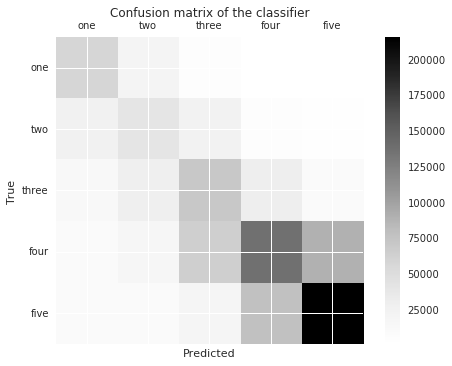

In [16]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', ngram_range=(1,2),
                                   max_df=0.6, min_df=0.01)),
    ('transformer', TfidfTransformer(use_idf=False)),
    ('classifier',  MultinomialNB(fit_prior=False)) ])

k_fold = KFold(n=len(reviews), n_folds=2)
scores = []
confusion = np.zeros(shape=(5,5))
for train_indices, test_indices in k_fold:
    train_text = reviews.iloc[train_indices]['Text'].values
    train_y = reviews.iloc[train_indices]['Rating_nom'].values

    test_text = reviews.iloc[test_indices]['Text'].values
    test_y = reviews.iloc[test_indices]['Rating_nom'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions, 
                                  labels = labels)
    print(metrics.classification_report(test_y, predictions, labels = labels))
print('Total reviews classified:', len(reviews))
#print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)
plot_confusion(confusion)

             precision    recall  f1-score   support

        one       0.68      0.69      0.68     21843
        two       0.50      0.40      0.45     24555
      three       0.51      0.41      0.46     38626
       four       0.55      0.60      0.57     80806
       five       0.69      0.71      0.70     84170

avg / total       0.59      0.60      0.59    250000

             precision    recall  f1-score   support

        one       0.68      0.69      0.68     22091
        two       0.50      0.41      0.45     24493
      three       0.52      0.41      0.46     38717
       four       0.55      0.60      0.58     80656
       five       0.69      0.72      0.70     84043

avg / total       0.60      0.60      0.60    250000

Total reviews classified: 500000
SVM with two fold cross validation on 150000 reviews took (min): 2122.65365038
Confusion matrix:
[[  30193.    8857.    2151.    1742.     991.]
 [  10006.   20091.   12621.    4955.    1375.]
 [   2689.    9244.   3208

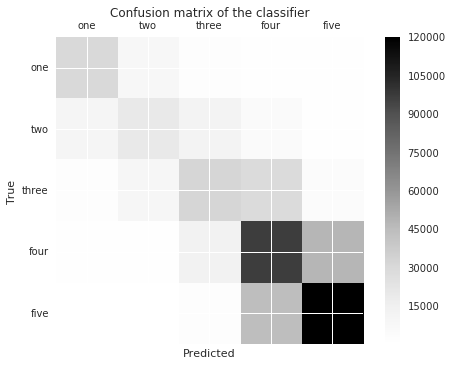

In [ ]:
from time import time
reviews_500K = reviews.sample(n = 500000)
t0 = time()
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,3), stop_words='english',
                                   max_df=0.7, min_df=100)),
    ('transformer', TfidfTransformer()),
    ('classifier',  SVC(kernel='linear')) ])

k_fold = KFold(n=len(reviews_500K), n_folds=2)
scores = []
confusion = np.zeros(shape=(5,5))
for train_indices, test_indices in k_fold:
    train_text = reviews_500K.iloc[train_indices]['Text'].values
    train_y = reviews_500K.iloc[train_indices]['Rating_nom'].values

    test_text = reviews_500K.iloc[test_indices]['Text'].values
    test_y = reviews_500K.iloc[test_indices]['Rating_nom'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions, 
                                  labels = labels)
    print(metrics.classification_report(test_y, predictions, labels = labels))

print('Total reviews classified:', len(reviews_500K))
print('SVM with two fold cross validation on 150000 reviews took (min):', (time()-t0)/60)
print('Confusion matrix:')
print(confusion)
plot_confusion(confusion)

In [42]:
labels = ['one', 'two', 'three', 'four', 'five']
reviews_sample = reviews.sample(n=300000)
y = reviews_sample.Rating_nom.values
X = reviews_sample.Text.values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=.4, random_state=123)

In [43]:
columns = ['pred_svm', 'pred_lr', 'pred_nb','pred_final']
index = np.arange(len(y_test)) # array of numbers for the number of samples
df = pd.DataFrame(columns=columns, index = index)

In [44]:
pipe1 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.6, min_df=0.01)),
    ('transformer', TfidfTransformer(use_idf=False)),
    ('classifier',  MultinomialNB(fit_prior=False)) ])
pipe1 = pipe1.fit(X_train, y_train)

df.pred_nb = pipe1.predict(X_test)

In [33]:
#df.pred_nb = pipe1.predict(X_test)

In [ ]:
pipe2 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.6, min_df=0.01)),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('classifier',  LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=200)) ])
pipe2 = pipe2.fit(X_train, y_train)

df.pred_lr = pipe2.predict(X_test)

In [34]:
#df.pred_lr = pipe2.predict(X_test)

In [ ]:
pipe3 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.6, min_df=0.01)),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('classifier',  SVC(kernel='linear')) ])
pipe3 = pipe3.fit(X_train, y_train)

df.pred_svm = pipe3.predict(X_test)

In [35]:
#df.pred_svm = pipe3.predict(X_test)

In [ ]:
df.head()

In [ ]:
mapping = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5}
df = df.replace({'pred_lr': mapping, 'pred_svm': mapping, 'pred_nb': mapping})
df.pred_final = (df.pred_lr+df.pred_nb+df.pred_svm)/3
df.head()

In [ ]:
df['actual'] = y_test
df.head()
df.pred_final = df.pred_final.round()
df.head(40)

In [ ]:
mapping = {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five'}
df = df.replace({'pred_final': mapping})

#df.head()
labels = ['one', 'two', 'three', 'four', 'five']

cm = metrics.confusion_matrix(y_test, df.pred_final, labels = labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Combined Classifiers')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(metrics.classification_report(y_test, df.pred_final, labels = labels))

In [ ]:
columns = ['LR','SVM','NB','Combined']
index = ['one','two','three','four','five']

precision = pd.DataFrame(columns=columns, index = index)
precision['Combined'] = [0.71,0.43,0.43,0.52,0.66]
precision['LR'] = [0.64,0.42,0.41,0.51,0.64]
precision['NB'] = [0.63,0.41,0.39,0.49,0.65]
precision['SVM'] = [0.61,0.42,0.41,0.51,0.64]
precision['p_r'] = 'precision'

recall = pd.DataFrame(columns=columns, index = index)
recall['Combined'] = [0.58,0.34,0.40,0.57,0.69]
recall['LR'] = [0.66,0.33,0.39,0.56,0.72]
recall['NB'] = [0.56,0.20,0.31,0.60,0.68]
recall['SVM'] = [0.6,0.33,0.39,0.52,0.68]
recall['p_r'] = 'recall'

In [ ]:
plt.figure(); 
precision.plot(); 
plt.ylabel('Precision')
plt.xlabel('Review rating')
plt.title('Precision of classification for different algorithms')
plt.legend(loc='best')

In [ ]:
plt.figure(); 
recall.plot();
plt.ylabel('Recall')
plt.xlabel('Review rating')
plt.title('Recall of classification for different algorithms')
plt.legend(loc='best')